Correlation: -0.6001159305782113, p-value: 3.3328494286511685e-55


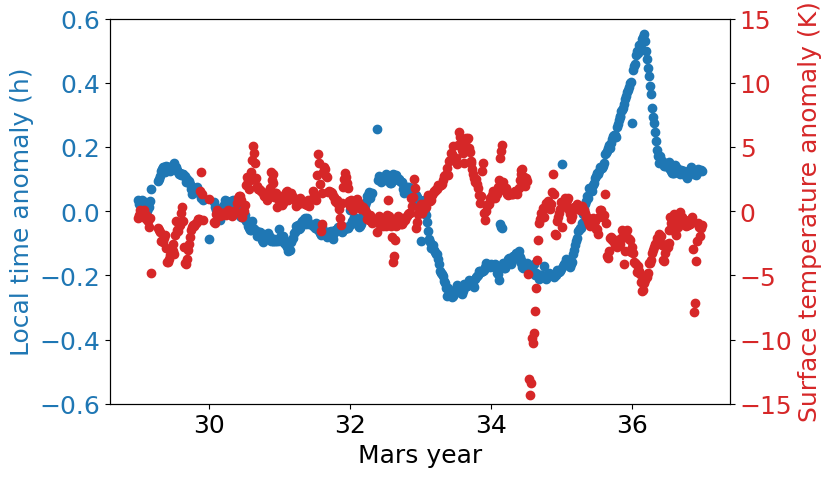

In [ ]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. Data Processing Functions
# ==========================================

def get_continuous_time(da: xr.DataArray) -> xr.DataArray:
    """
    Collapse Mars Year (MY) and Ls into a single continuous fractional coordinate.
    """
    # Create new continuous coordinate (MY + Ls/360)
    my_frac = da.coords["MY"] + da.coords["Ls"] / 360
    
    # Stack MY and Ls into one dimension
    da_stacked = da.stack(sample=("MY", "Ls"))
    
    # Assign new continuous coordinate and rename to MY for plotting compatibility
    da_stacked = da_stacked.assign_coords(sample=my_frac.values.flatten())
    da_stacked = da_stacked.rename({"sample": "MY"})
    
    return da_stacked

def weight_mean(data: xr.DataArray) -> xr.DataArray:
    """
    Calculate cosine-weighted latitudinal mean.
    """
    weights = np.cos(np.deg2rad(data.Lat))
    weights.name = "weights"
    tsurf_weighted = data.weighted(weights)
    return tsurf_weighted.mean(("Lat", "Lon"))

def get_anomaly_weighted(ds: xr.Dataset, var_name: str, 
                         my_range: tuple, ls_range: tuple, lat_range: tuple) -> xr.DataArray:
    """
    Extracts variable, calculates climatology anomaly, collapses time, 
    and computes weighted mean.
    """
    # Select Data
    da = ds[var_name].loc[my_range[0]:my_range[1], 
                          ls_range[0]:ls_range[1], 
                          lat_range[0]:lat_range[1]]
    
    # Calculate Anomaly
    da_clim = da.mean(dim='MY')
    da = da - da_clim
    
    # Process Coordinates
    da = get_continuous_time(da)
    
    # Weighted Mean
    da_weight = weight_mean(da)
    
    return da_weight.dropna(dim='MY')

# ==========================================
# 2. Main Calculation
# ==========================================

# Configuration
FILE_PATH = '../data/MCS_tsurf_ltst_15.nc'
MY_RANGE = (29, 36)
LS_RANGE = (0, 360)
LAT_RANGE = (-60, 60)

# Load Data
ds_mcs = xr.open_dataset(FILE_PATH)

# Process Variables
ltst_weight = get_anomaly_weighted(ds_mcs, 'ltst', MY_RANGE, LS_RANGE, LAT_RANGE)
tsurf_weight = get_anomaly_weighted(ds_mcs, 'tsurf', MY_RANGE, LS_RANGE, LAT_RANGE)

# Calculate Statistics
# Ensure alignment in case dropna removed different indices
common_idx = np.intersect1d(ltst_weight.MY, tsurf_weight.MY)
cc, p = pearsonr(ltst_weight.sel(MY=common_idx), tsurf_weight.sel(MY=common_idx))
print(f"Correlation: {cc}, p-value: {p}")

# ==========================================
# 3. Plotting (Original Style Preserved)
# ==========================================

fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Axis 1: Local Time ---
color1 = 'tab:blue'
ax1.scatter(ltst_weight.MY.values, ltst_weight.values, c=color1, label='Local time anomaly')

ax1.set_xlabel('Mars year', fontdict={'size': 18})
ax1.set_ylabel('Local time anomaly (h)', color=color1, fontdict={'size': 18})
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(-0.6, 0.6) 
ax1.tick_params(labelsize=18)

# --- Axis 2: Surface Temperature ---
ax2 = ax1.twinx()
color2 = 'tab:red'

ax2.scatter(tsurf_weight.MY.values, tsurf_weight.values, c=color2, label='Surface temperature')

ax2.set_ylabel('Surface temperature anomaly (K)', color=color2, fontdict={'size': 18})
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(-15, 15)
ax2.tick_params(labelsize=18)

plt.show()